In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.proportion import proportions_chisquare
from scipy.stats import chisquare
import pickle
from bs4 import BeautifulSoup
from collections import defaultdict
import requests
%matplotlib inline


/usr/local/lib/python3.5/dist-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


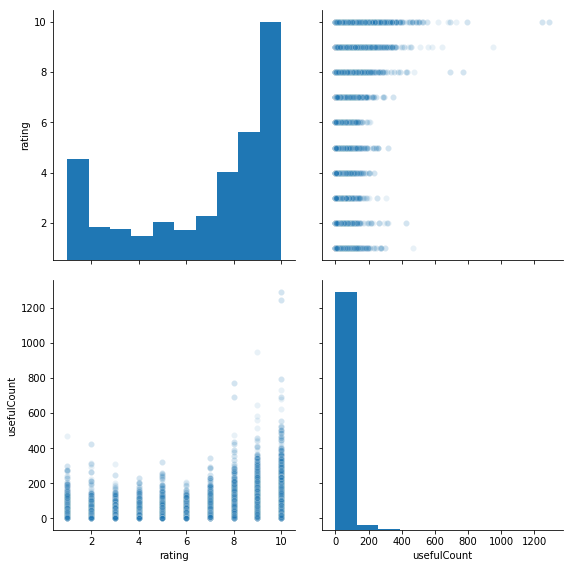

In [10]:
df = pd.read_csv('drugsCom_raw/drugsComTrain_raw.tsv',sep='\t',index_col=0)
sns.pairplot(df, plot_kws={'alpha':0.1},size=4)

In [11]:
df.shape

(161297, 6)

In [12]:
df['date'] = pd.to_datetime(df['date'])

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 161297 entries, 206461 to 215220
Data columns (total 6 columns):
drugName       161297 non-null object
condition      160398 non-null object
review         161297 non-null object
rating         161297 non-null float64
date           161297 non-null datetime64[ns]
usefulCount    161297 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 13.6+ MB


# 1. EDA

## Total number of comments posted each day

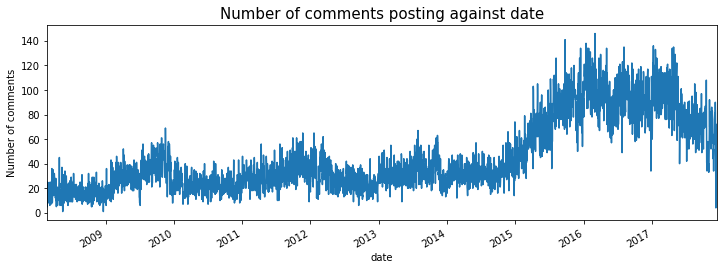

In [27]:
df.groupby('date').size().plot(figsize=(12,4))
plt.ylabel('Number of comments')
plt.title("Number of comments posting against date",fontsize=15)
plt.savefig("Plot/num_comments_date.png")

## Total number of comments posted each month

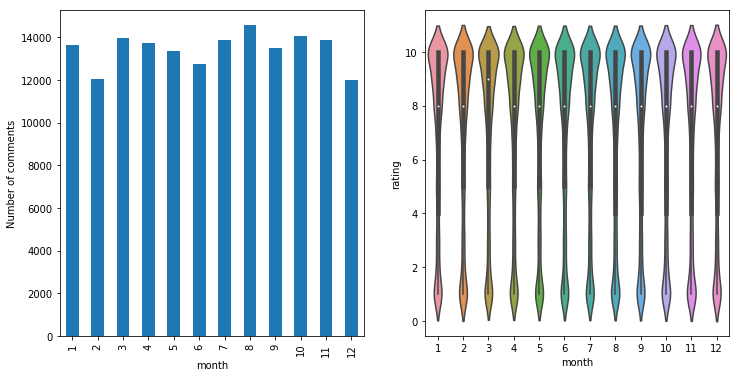

In [18]:
df['month'] = df['date'].apply(lambda x: x.month)

plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
df.groupby('month').size().plot(kind='bar')
plt.ylabel('Number of comments')

plt.subplot(1, 2, 2)
sns.violinplot(data=df,x='month',y='rating')

## Total number of comments for each condition

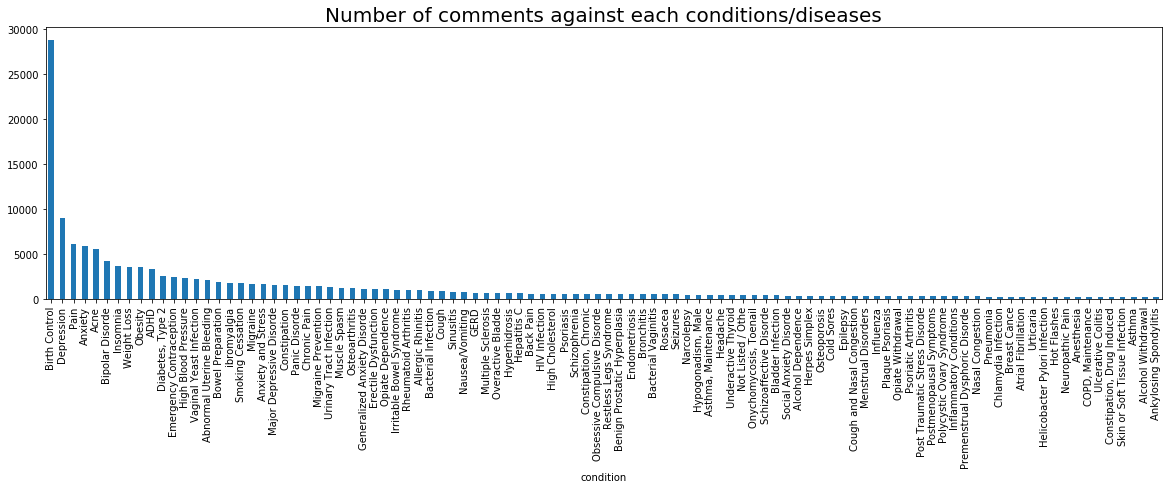

In [24]:
df_con_mon = pd.DataFrame(df.groupby(['condition','month']).size()).reset_index()

df_con_mon_pivot = df_con_mon.pivot_table(index='condition',columns='month',values=0)

plt.figure(figsize=(20,5))
df_con_mon_pivot.sum(1).sort_values(ascending=False).iloc[:100].plot(kind='bar')
plt.title("Number of comments against each conditions/diseases",fontsize=20)
plt.savefig("Plot/num_comments_each_condition.png")


## Total number of comments for each condition against each month

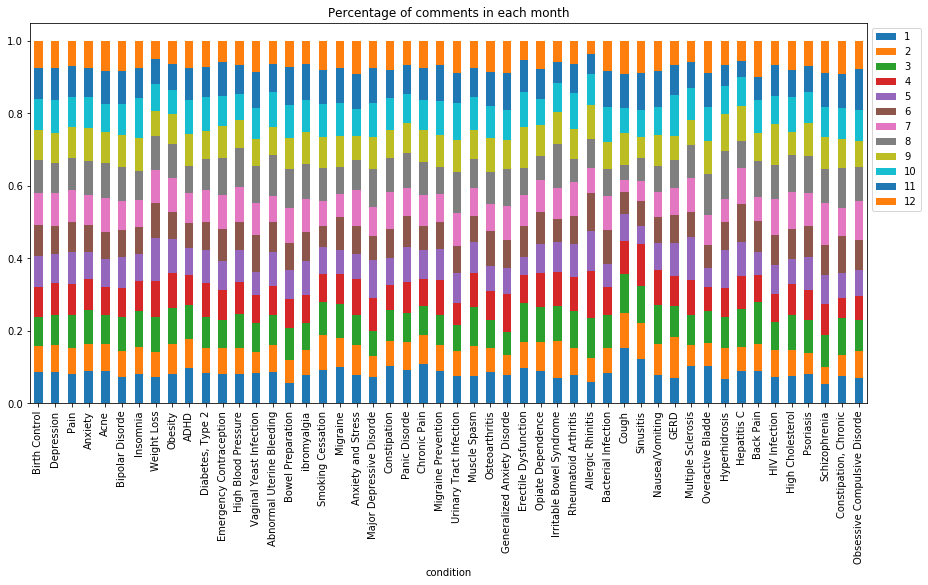

In [38]:
n = 50
top_n_index = df_con_mon_pivot.sum(1).sort_values(ascending=False).iloc[:n].index
tm_con_mon_pivot = df_con_mon_pivot.loc[top_n_index]
tm_con_mon_pivot_per = tm_con_mon_pivot.div(tm_con_mon_pivot.sum(1), axis=0)
tm_con_mon_pivot_per.plot.bar(stacked=True, figsize=(15,7))
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title("Percentage of comments in each month")
plt.savefig("Per_comments_month.png")

In [39]:
## avg of comments for each condition in each month
df_con_mon_pivot_sorted = df_con_mon_pivot.loc[df_con_mon_pivot.sum(1).sort_values(ascending=False).index]

df_con_mon_pivot_sorted.sum() / len(df_con_mon_pivot_sorted)
#mon_sick_per = df_con_mon_pivot_sorted.sum()/df_con_mon_pivot_sorted.sum().sum()

month
1     15.356335
2     13.541855
3     15.686652
4     15.442308
5     15.020362
6     14.348416
7     15.580317
8     16.380090
9     15.158371
10    15.804299
11    15.606335
12    13.520362
dtype: float64

In [40]:
sum_months = df_con_mon_pivot_sorted.sum()
all_sum = sum_months.sum()

i = 0 
#df_con_mon_pivot_sorted.iloc[i,:]
expected = df_con_mon_pivot_sorted.sum(0) * (df_con_mon_pivot_sorted.iloc[i,:].sum() / all_sum)
observed = df_con_mon_pivot_sorted.iloc[i,:]
chisquare(observed,f_exp=expected)

Power_divergenceResult(statistic=38.935465364569865, pvalue=5.4327938627447377e-05)

In [41]:
sum_months = df_con_mon_pivot_sorted.sum()
all_sum = sum_months.sum()
chi_result =[]

## only take T > 5 (the cell need 5 records at least)
df_con_mon_pivot_sorted_T5 = df_con_mon_pivot_sorted[(df_con_mon_pivot_sorted > 5).all(1)]
df_con_mon_pivot_sorted_T5.head()

## compare expected and observed using chi-square test
for idx in df_con_mon_pivot_sorted_T5.index:
    ## use 
    expected = df_con_mon_pivot_sorted.sum(0) * (df_con_mon_pivot_sorted.loc[idx,:].sum() / all_sum)
    observed = df_con_mon_pivot_sorted_T5.loc[idx,:]
    
    chi_result.append([idx,chisquare(observed,f_exp=expected)])

In [42]:
df_chi = pd.DataFrame([[a[0],a[1].statistic,a[1].pvalue] for a in chi_result])
df_chi.columns = ['condition','statistic','pvalue']
df_chi_sorted = df_chi[df_chi['pvalue'] < 0.05].sort_values('pvalue')

df_chi_sorted.head()

,condition,statistic,pvalue
7,Weight Loss,145.652500,1.149992e-25
35,Cough,129.962039,1.771886e-22
33,Allergic Rhinitis,89.940100,1.712822e-14
36,Sinusitis,72.581047,3.936670e-11
72,Cough and Nasal Congestion,71.094673,7.562344e-11


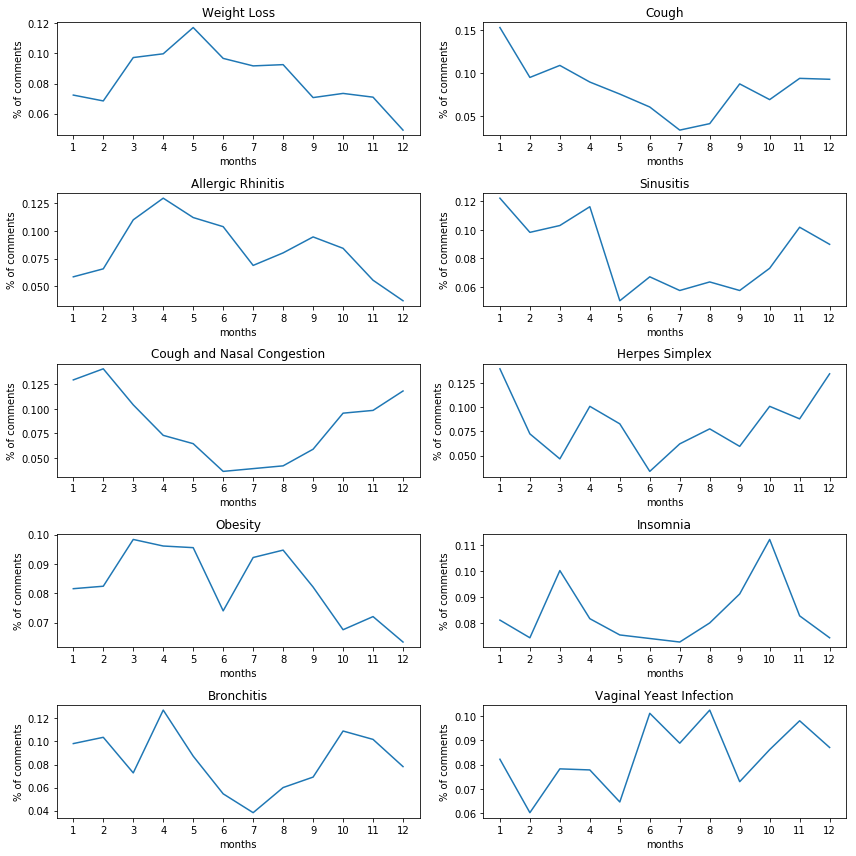

In [44]:

plt.figure(figsize=(12,12))
i =1
for idx in df_chi_sorted['condition'][:10]:
    
    each = df_con_mon_pivot_sorted_T5.loc[idx,:]/df_con_mon_pivot_sorted_T5.loc[idx,:].sum()
    
    plt.subplot(5, 2, i)
    plt.title(idx)
    plt.plot(each)
    plt.xticks(np.arange(1,13,1))
    plt.xlabel('months')
    plt.ylabel('% of comments')
    i = i +1
    
plt.tight_layout()
plt.savefig("Top_condition_signif_month.png")

# 2. NLP

## 2.1 Sentiment Analysis
### 2.1.1 intial quick predition about rating (Logistic regression)

In [4]:
## remove special symbol
def rm_sym(df):
    df['review'] = df['review'].str.replace("&#039;",'\'')
    df['review'].head()
    df['rating_cate'] = ''
    df.loc[df['rating'] >= 7,'rating_cate'] = 'high'
    df.loc[df['rating'] <= 4,'rating_cate'] = 'low'
    df.loc[(df['rating'] > 4) & (df['rating'] < 7),'rating_cate'] = 'medium'
    return df
df = rm_sym(df)

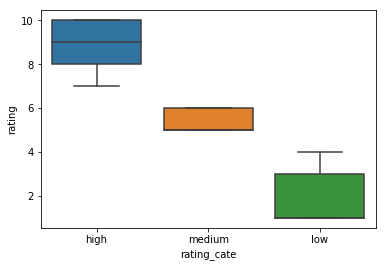

In [5]:
sns.boxplot(x=df['rating_cate'],y=df['rating'])

In [6]:
df_tem = df.sample(20000)
df_tem.groupby('rating_cate').size() / df_tem.groupby('rating_cate').size().sum()

rating_cate
high      0.6655
low       0.2453
medium    0.0892
dtype: float64

In [23]:
!ls drugsCom_raw

drugsComTest_raw.tsv  drugsComTrain_raw.tsv


In [24]:
test = pd.read_csv("drugsCom_raw/drugsComTest_raw.tsv",sep='\t', index_col=0)
test = rm_sym(test)

In [25]:
df.shape

(161297, 7)

In [26]:
test.shape

(53766, 7)

In [40]:
import nltk
from nltk.tokenize import word_tokenize
import string
from nltk.stem.snowball import SnowballStemmer
import re
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from wordcloud import WordCloud



## only need to remove punctuation and stemize
stemmer = SnowballStemmer('english')

def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

def tokenize(text):
    text = "".join([ch for ch in text if ch not in string.punctuation])
    tokens = nltk.word_tokenize(text)
    stems = stem_tokens(tokens, stemmer)
    return stems

In [11]:
## Generate table of words with their counts
con_vec = TfidfVectorizer(stop_words='english',tokenizer=tokenize)
X_train = con_vec.fit_transform(df_tem['review'])
#target_3 = pd.get_dummies(df_tem['rating_cate'])
X_train = pd.DataFrame(X_train.toarray(),columns=con_vec.get_feature_names())
y_train = df_tem['rating_cate']

/Users/jzz0026/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [27]:
X_test = con_vec.transform(test['review'])
X_test = pd.DataFrame(X_test.toarray(),columns=con_vec.get_feature_names())

In [28]:
y_test = test['rating_cate']
X_test.head()

,0,00,0002,0009,001,0025,003,004,005,005mg,...,zyprexai,zyrtec,zyvox,zzquill,zzzquil,☺,☺i,♀,♡,⭐️
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
X_train.head()

,0,00,0002,0009,001,0025,003,004,005,005mg,...,zyprexai,zyrtec,zyvox,zzquill,zzzquil,☺,☺i,♀,♡,⭐️
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
print(X_train.shape)
print(X_test.shape)

(20000, 22209)
(53766, 22209)


### cross validation

In [ ]:
## n_gram -> count word 
lr = LogisticRegression(penalty='l1',multi_class='auto',solver='saga')
#lr.fit(X,target_3.iloc[:,0])

cv_score = cross_val_score(lr,X_train,y_train,scoring='accuracy',cv=3,n_jobs=-1)

In [55]:
## TfidfVectorizer

## n = 20000, penalty='l1',multi_class='auto',solver='saga'
## array([0.75971201, 0.75446228, 0.75652565])

## n = 20000, penalty='l1',multi_class='auto',solver='saga'
## array([0.73560288, 0.73826309, 0.739985  ])

## CountVectorizer

## n = 10000, penalty='l1',multi_class='auto',solver='saga'
## array([0.70475705, 0.71251387, 0.70633158])

## n = 20000, penalty='l1',multi_class='auto',solver='saga'
## array([0.71475705, 0.72251387, 0.72633158])

### test set predition

In [34]:
lr = LogisticRegression(penalty='l1',multi_class='auto',solver='saga')
lr.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='auto',
          n_jobs=None, penalty='l1', random_state=None, solver='saga',
          tol=0.0001, verbose=0, warm_start=False)

In [35]:
y_test_predict = lr.predict(X_test)

In [39]:
from sklearn.metrics import accuracy_score 
accuracy_score(y_test,y_test_predict)

0.7619127329539114

### importance ranking based on coefficients

In [45]:
coef_lr = pd.DataFrame(lr.coef_,columns=X_train.columns,index=lr.classes_)

Rating as "high": top 20 of Positive coeffients
miracl       12.614183
amaz          8.729059
best          6.631751
love          6.435537
life          5.251808
occasion      5.111043
lifesav       4.948531
grate         4.910911
save          4.820987
happier       4.652831
condom        4.618370
fade          4.523015
saver         4.508887
tremend       4.469192
gone          4.375813
complaint     4.331121
unprotect     4.296105
otherwis      4.078329
overal        3.988319
happi         3.969785
Name: high, dtype: float64

Rating as "high": top 20 of Negative coeffients
remov        -4.992940
discontinu   -4.456865
ruin         -4.442616
wors         -4.152632
tomorrow     -3.934887
switch       -3.925210
disappoint   -3.610191
gain         -3.607523
temper       -3.235686
swollen      -3.153671
crazi        -3.062168
frustrat     -3.049834
nightmar     -2.939620
horribl      -2.863846
awak         -2.851809
list         -2.804589
vision       -2.728705
answer       -2.726729
me

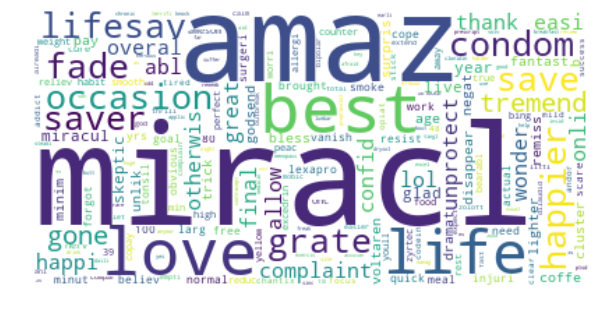

In [56]:
def top_20_pos_neg_wordcloud(category):
    print('Rating as "' + category +'": top 20 of Positive coeffients')
    print(coef_lr.loc[category].nlargest(20))

    print('\nRating as "' + category +'": top 20 of Negative coeffients')
    print(coef_lr.loc[category].nsmallest(20))

    wordcloud = WordCloud(contour_width=1,background_color='white')
    wordcloud.generate_from_frequencies(frequencies=coef_lr.loc[category])

    plt.figure(figsize=(10,8))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    
top_20_pos_neg_wordcloud('high')

Rating as "medium": top 20 of Positive coeffients
howev        3.822645
ejacul       3.664788
hope         3.402617
pimpl        2.565097
workedi      2.505154
combin       2.305556
pray         2.043904
50mg         2.023167
towel        1.882224
heartburn    1.789934
13lbs        1.707703
yi           1.698280
decemb       1.654886
becom        1.617910
think        1.617901
okay         1.544979
stomach      1.523220
mgs          1.451096
mixtur       1.377750
weird        1.314475
Name: medium, dtype: float64

Rating as "medium": top 20 of Negative coeffients
recommend   -6.507260
pleas       -2.285493
woke        -2.109755
appoint     -1.705737
28          -1.634628
noth        -1.609214
ear         -1.370148
diet        -1.335489
nose        -1.334534
insid       -1.230864
suffer      -1.216188
life        -1.171746
husband     -1.037458
happen      -0.989958
brand       -0.986959
expens      -0.977815
exercis     -0.975617
hospit      -0.974622
type        -0.964211
generic     

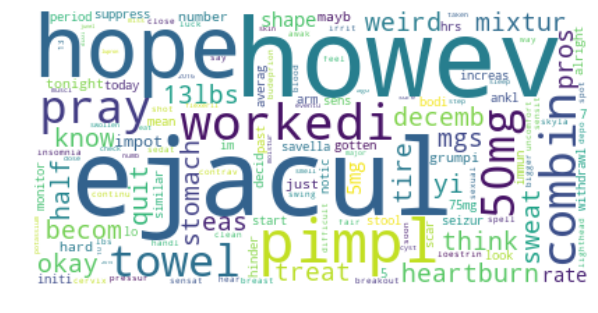

In [57]:
top_20_pos_neg_wordcloud('medium')

Rating as "low": top 20 of Positive coeffients
money         7.546683
destroy       6.463550
wast          4.599409
worst         4.483666
wors          4.021004
angri         3.816367
disappoint    3.707516
danger        3.447815
aw            3.290302
advis         3.286258
ridicul       3.264879
violent       3.195435
disturb       3.078343
depress       2.862851
miser         2.753286
opposit       2.747507
useless       2.739942
thought       2.562322
vagina        2.469592
ineffect      2.445997
Name: low, dtype: float64

Rating as "low": top 20 of Negative coeffients
awesom      -5.884372
excel       -5.388067
elimin      -4.830151
downsid     -4.627440
relax       -3.987879
far         -3.952750
moistur     -3.768545
stress      -3.433804
worri       -3.390331
clear       -3.389607
great       -3.311526
import      -3.290698
better      -3.276486
oxycontin   -3.193824
16          -3.001667
zofran      -2.910277
percocet    -2.851606
withdrawl   -2.824007
lot         -2.811619
s

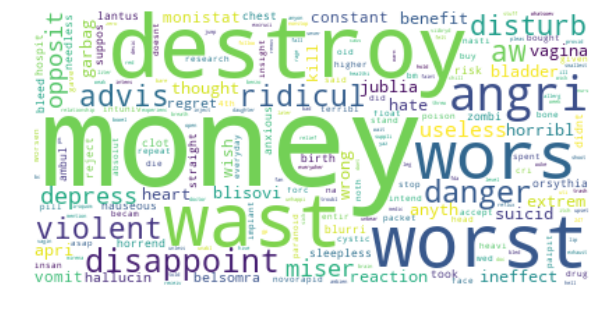

In [58]:
top_20_pos_neg_wordcloud('low')

### 2.1.2 Random forest classifier

In [89]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=200,n_jobs=-1)
rfc_cv_score = cross_val_score(lr,X_train,y_train,scoring='accuracy',cv=3,n_jobs=-1)

In [91]:
rfc_cv_score

## n_sample = 20000, n_estimators=200
## array([0.76019796, 0.75851207, 0.75513878])

array([0.76019796, 0.75851207, 0.75513878])

In [86]:
rfc = RandomForestClassifier(n_estimators=200,n_jobs=-1)
rfc.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [87]:
y_test_rfc_predict = rfc.predict(X_test)

In [88]:
accuracy_score(y_test,y_test_rfc_predict)

0.7269091991221218

In [ ]:
# 0.72

### 2.1.3 Gradient boosting classifier

In [114]:
from sklearn.ensemble import GradientBoostingClassifier

df_tem2 = df.sample(5000)
df_tem2.groupby('rating_cate').size() / df_tem2.groupby('rating_cate').size().sum()

## Generate table of words with their counts
con_vec = TfidfVectorizer(stop_words='english',tokenizer=tokenize)
X_train = con_vec.fit_transform(df_tem2['review'])
#target_3 = pd.get_dummies(df_tem['rating_cate'])
#X_train = pd.DataFrame(X_train.toarray(),columns=con_vec.get_feature_names())
y_train = df_tem2['rating_cate']

/Users/jzz0026/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [150]:
test = pd.read_csv("drugsCom_raw/drugsComTest_raw.tsv",sep='\t', index_col=0)
test = rm_sym(test)
X_test = con_vec.transform(test['review'])


In [117]:
gbc = GradientBoostingClassifier(n_estimators=300)
gbc_cv_score = cross_val_score(gbc,X_train,y_train,scoring='accuracy',cv=3,n_jobs=-1)
gbc_cv_score

array([0.71025795, 0.69946011, 0.69267707])

In [ ]:
## cv
## n_sample=20000, n_estimators=600
## ['0.73665267', '0.74066297', '0.73713428']

## n_sample=500, n_estimators=200
## array([0.70845831, 0.69886023, 0.69627851])

## test set
## n_sample=20000, n_estimators=600
## 0.7498419075252017

In [153]:
# filename = "gbc_20000_600_gbc.sav"
# infile = open(filename,'rb')
# gbc = pickle.load(infile)
# y_test_gbc_predict = gbc.predict(X_test)

### 2.1.4 SVM

In [185]:
from sklearn.svm import SVC

df = pd.read_csv('drugsCom_raw/drugsComTrain_raw.tsv',sep='\t',index_col=0)
df = rm_sym(test)
df_tem3 = df.sample(40000)

test = pd.read_csv("drugsCom_raw/drugsComTest_raw.tsv",sep='\t', index_col=0)
test = rm_sym(test)

In [186]:
## Generate table of words with their counts
con_vec = TfidfVectorizer(stop_words='english',tokenizer=tokenize)
X_train = con_vec.fit_transform(df_tem3['review'])
y_train = df_tem3['rating_cate']

## test set

X_test = con_vec.transform(test['review'])
y_test = test['rating_cate']

/Users/jzz0026/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


#### rbf

In [176]:
svm_rbf = SVC(kernel='rbf')
gbc_cv_score = cross_val_score(svm_rbf,X_train,y_train,scoring='accuracy',cv=3,n_jobs=-1)
gbc_cv_score

array([0.66061788, 0.66071696, 0.66076519])

#### poly

In [175]:
svm_poly = SVC(kernel='poly')
gbc_cv_score = cross_val_score(svm_poly,X_train,y_train,scoring='accuracy',cv=3,n_jobs=-1)
gbc_cv_score

array([0.66061788, 0.66071696, 0.66076519])

#### linear

In [171]:
svm_lin = SVC(kernel='linear')
gbc_cv_score = cross_val_score(svm_lin,X_train,y_train,scoring='accuracy',cv=3,n_jobs=-1)
gbc_cv_score

array([0.75794841, 0.76256187, 0.75213803])

In [187]:
svm_lin = SVC(kernel='linear')
svm_lin.fit(X_train,y_train)
y_test_pred_svm_lin = svm_lin.predict(X_test)

In [188]:
accuracy_score(y_test,y_test_pred_svm_lin)

0.8062158241267716